In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

from sklearn.exceptions import ConvergenceWarning
import warnings

from tqdm import tqdm

In [3]:
batting_df = pd.read_pickle('./FinalDFs/PostEDA/batting_df.pkl')
bowling_df = pd.read_pickle('./FinalDFs/PostEDA/bowling_df.pkl')

# **Part 1: Data Preprocessing**

## **(I) Dropping Irrelevant Columns**

As we saw in our EDA notebook, there were quite a few of the numeric variables that were very closely related to each other. For example, in `batting_df`, the columns with `balls_faced` and `total_runs` had very high correlation numbers. Therefore, we will exclude one of these sets from our analysis.

In [3]:
# bat_corr = batting_df.corr()

# threshold = 0.8 
# highly_correlated_features = set()

# # Iterate through the correlation matrix
# for i in range(len(bat_corr.columns)):
#     for j in range(i):
#         if abs(bat_corr.iloc[i, j]) > threshold:
#             # Add the feature names to the set of highly correlated features
#             feature_i = bat_corr.columns[i]
#             feature_j = bat_corr.columns[j]
#             highly_correlated_features.add((feature_i, feature_j))

# print("Highly Correlated Features:")
# for feature_pair in highly_correlated_features:
#     print(feature_pair)

Highly Correlated Features:
('4s', 'balls_faced')
('6s', 'total_runs')
('50s', 'balls_faced')
('4s', '50s')
('4s', 'total_runs')
('50s', 'total_runs')
('total_runs', 'balls_faced')
('NY_SalaryUSD', 'SalaryUSD')


In [5]:
batting_filtered = batting_df.copy()

# drop_bat_cols = ['50s', 'balls_faced', '4s', '6s']
# batting_filtered = batting_filtered.drop(columns=drop_bat_cols)# 

In [5]:
# bowl_corr = bowling_df.corr()

# threshold = 0.8 
# highly_correlated_features = set()

# # Iterate through the correlation matrix
# for i in range(len(bowl_corr.columns)):
#     for j in range(i):
#         if abs(bowl_corr.iloc[i, j]) > threshold:
#             # Add the feature names to the set of highly correlated features
#             feature_i = bowl_corr.columns[i]
#             feature_j = bowl_corr.columns[j]
#             highly_correlated_features.add((feature_i, feature_j))

# print("Highly Correlated Features:")
# for feature_pair in highly_correlated_features:
#     print(feature_pair)

Highly Correlated Features:
('strike_rate', 'bowling_avg')
('6s', 'total_runs')
('total_wickets', 'total_runs')
('total_wickets', 'balls_bowled')
('balls_bowled', 'MatchCount')
('total_runs', 'balls_bowled')
('4s', 'total_runs')
('dots', 'total_wickets')
('dots', 'balls_bowled')
('dots', 'total_runs')
('4s', 'balls_bowled')
('4s', 'dots')
('total_runs', 'MatchCount')


In [6]:
bowling_filtered = bowling_df.copy()

# drop_bowl_cols = ['total_runs', 'strike_rate', '4s', '6s']
# bowling_filtered = bowling_filtered.drop(columns=drop_bowl_cols)

## **(II) Scaling the Numeric Columns**

The next step is to scale the numeric columns using the `StandardScaler`.

In [7]:
scaler = StandardScaler()

bat_num_cols = [col for col in batting_filtered.select_dtypes(include=[np.number]).columns if col not in ['Season', 'Role', 'changed_teams']]
bowl_num_cols = [col for col in bowling_filtered.select_dtypes(include=[np.number]).columns if col not in ['Season', 'Role', 'changed_teams']]

In [8]:
batting_filtered[bat_num_cols] = scaler.fit_transform(batting_filtered[bat_num_cols])
bowling_filtered[bowl_num_cols] = scaler.fit_transform(bowling_filtered[bowl_num_cols])

## **(III) Getting Dummies for the Categorical Columns**

The final step in data preprocessing is getting dummies for the categorical columns.

In [9]:
batting_filtered = pd.get_dummies(batting_filtered, columns=['Country', 'Team'])

In [10]:
bowling_filtered = pd.get_dummies(bowling_filtered, columns=['Country', 'Team'])

# **Part 2: Train-Test Split**

In [11]:
batting_filtered = batting_filtered.sort_values(by='Season')
bowling_filtered = bowling_filtered.sort_values(by='Season')

In [12]:
batting_train, batting_test = train_test_split(batting_filtered, test_size=.2)
bowling_train, bowling_test = train_test_split(bowling_filtered, test_size=.2)

In [13]:
X_train_bat = batting_train.drop(columns=['Player', 'NY_SalaryUSD'])
y_train_bat = batting_train['NY_SalaryUSD']

X_test_bat = batting_test.drop(columns=['Player', 'NY_SalaryUSD'])
y_test_bat = batting_test['NY_SalaryUSD']

In [14]:
X_train_bowl = bowling_train.drop(columns=['Player', 'NY_SalaryUSD'])
y_train_bowl = bowling_train['NY_SalaryUSD']

X_test_bowl = bowling_test.drop(columns=['Player', 'NY_SalaryUSD'])
y_test_bowl = bowling_test['NY_SalaryUSD']

# **Part 3: Batting Models**

In [15]:
mean_target = y_train_bat.mean()

y_pred_mean = np.full(y_test_bat.shape, mean_target)

mae_mean = mean_absolute_error(y_test_bat, y_pred_mean)
mse_mean = mean_squared_error(y_test_bat, y_pred_mean)
r2_mean = r2_score(y_test_bat, y_pred_mean)

print("Mean-Based Model:")
print("MAE:", mae_mean)
print("MSE:", mse_mean)
print("R^2:", r2_mean)

Mean-Based Model:
MAE: 0.8007486813124508
MSE: 1.0790851753890716
R^2: -0.0017950221480325101


## (I) Linear Models

In [16]:
linear_model = LinearRegression()
linear_model.fit(X_train_bat, y_train_bat)
y_pred_linear = linear_model.predict(X_test_bat)

mae_linear = mean_absolute_error(y_test_bat, y_pred_linear)
mse_linear = mean_squared_error(y_test_bat, y_pred_linear)
r2_linear = r2_score(y_test_bat, y_pred_linear)

print("\nLinear Regression Model:")
print("MAE:", mae_linear)
print("MSE:", mse_linear)
print("R^2:", r2_linear)


Linear Regression Model:
MAE: 0.3835942770611218
MSE: 0.4050766214365047
R^2: 0.6239372459200748


In [17]:
constant_feature_mask = X_train_bat.apply(lambda col: col.nunique() != 1)
X_train_bat = X_train_bat.loc[:, constant_feature_mask]
X_test_bat = X_test_bat.loc[:, constant_feature_mask]

In [18]:
k=10
selector = SelectKBest(score_func=f_regression, k=k)

X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
X_test_bat_selected = selector.transform(X_test_bat)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_bat.columns[selected_feature_indices]

In [19]:
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_bat_selected, y_train_bat)
y_pred_linear_selected = linear_model_selected.predict(X_test_bat_selected)

mae_linear_selected = mean_absolute_error(y_test_bat, y_pred_linear_selected)
mse_linear_selected = mean_squared_error(y_test_bat, y_pred_linear_selected)
r2_linear_selected = r2_score(y_test_bat, y_pred_linear_selected)

print("\nLinear Regression Model with Selected Features:")
print("Selected Features:", selected_feature_names)
print("MAE:", mae_linear_selected)
print("MSE:", mse_linear_selected)
print("R^2:", r2_linear_selected)


Linear Regression Model with Selected Features:
Selected Features: Index(['SalaryUSD', 'MatchCount', 'SeasonCount', 'balls_faced', 'total_runs',
       'batting_avg', '50s', '4s', '6s', 'Country_Uncapped'],
      dtype='object')
MAE: 0.3706223694528129
MSE: 0.4071944932784418
R^2: 0.6219710679786208


In [20]:
k_values = range(1, 11)

linear_r2_scores = []
elastic_net_r2_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
    X_test_bat_selected = selector.transform(X_test_bat)

    linear_model_selected = LinearRegression()
    linear_model_selected.fit(X_train_bat_selected, y_train_bat)
    y_pred_linear_selected = linear_model_selected.predict(X_test_bat_selected)
    r2 = r2_score(y_test_bat, y_pred_linear_selected)
    linear_r2_scores.append(r2)

    # ElasticNet Regression
    elastic_net_model = ElasticNet()
    elastic_net_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_elastic_net_selected = elastic_net_model.predict(X_test_bat_selected)
    elastic_net_r2_scores.append(r2_score(y_test_bat, y_pred_elastic_net_selected))

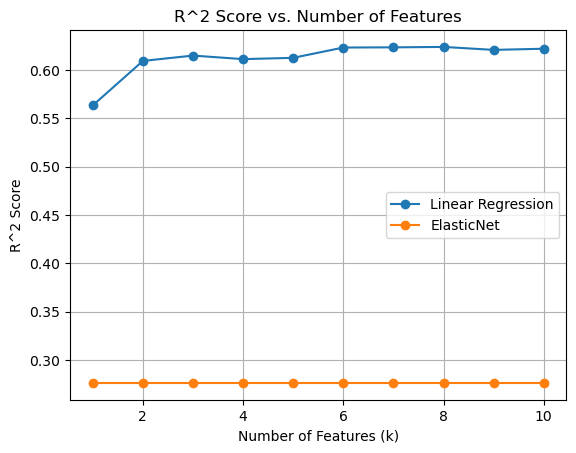

In [21]:
plt.plot(k_values, linear_r2_scores, label='Linear Regression', marker='o')
plt.plot(k_values, elastic_net_r2_scores, label='ElasticNet', marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('R^2 Score')
plt.title('R^2 Score vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

## (II) Other Models

In [26]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_bat, y_train_bat)
y_pred_rf = rf_model.predict(X_test_bat)

mae_rf = mean_absolute_error(y_test_bat, y_pred_rf)
mse_rf = mean_squared_error(y_test_bat, y_pred_rf)
r2_rf = r2_score(y_test_bat, y_pred_rf)

print("\nRandom Forest Regression Model:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("R^2:", r2_rf)


Random Forest Regression Model:
MAE: 0.41542644730519596
MSE: 0.501582021840477
R^2: 0.5343441054154394


In [27]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train_bat, y_train_bat)
y_pred_gb = gb_model.predict(X_test_bat)

mae_gb = mean_absolute_error(y_test_bat, y_pred_gb)
mse_gb = mean_squared_error(y_test_bat, y_pred_gb)
r2_gb = r2_score(y_test_bat, y_pred_gb)

print("\nGradient Boosting Regression Model:")
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("R^2:", r2_gb)


Gradient Boosting Regression Model:
MAE: 0.40996379450922177
MSE: 0.46036444060406934
R^2: 0.5726094515154148


In [28]:
sv_model = SVR()
sv_model.fit(X_train_bat, y_train_bat)
y_pred_sv = sv_model.predict(X_test_bat)

mae_sv = mean_absolute_error(y_test_bat, y_pred_sv)
mse_sv = mean_squared_error(y_test_bat, y_pred_sv)
r2_sv = r2_score(y_test_bat, y_pred_sv)

print("\nSupport Vector Regression Model:")
print("MAE:", mae_sv)
print("MSE:", mse_sv)
print("R^2:", r2_sv)


Support Vector Regression Model:
MAE: 0.7711945319550346
MSE: 1.1718160520631837
R^2: -0.08788399155496918


In [29]:
k_values = range(1, 11)
random_forest_r2_scores = []
gradient_boosting_r2_scores = []
svm_r2_scores = []
knn_r2_scores = []
xgboost_r2_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
    X_test_bat_selected = selector.transform(X_test_bat)

    # Random Forest Regression
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_rf_selected = rf_model.predict(X_test_bat_selected)
    random_forest_r2_scores.append(r2_score(y_test_bat, y_pred_rf_selected))

    # Gradient Boosting Regression
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_gb_selected = gb_model.predict(X_test_bat_selected)
    gradient_boosting_r2_scores.append(r2_score(y_test_bat, y_pred_gb_selected))

    # Support Vector Regression (SVR)
    svr_model = SVR()
    svr_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_svr_selected = svr_model.predict(X_test_bat_selected)
    svm_r2_scores.append(r2_score(y_test_bat, y_pred_svr_selected))

    # K-Nearest Neighbors Regression
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_knn_selected = knn_model.predict(X_test_bat_selected)
    knn_r2_scores.append(r2_score(y_test_bat, y_pred_knn_selected))

    # XGBoost Regression
    xgboost_model = xgb.XGBRegressor()
    xgboost_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_xgboost_selected = xgboost_model.predict(X_test_bat_selected)
    xgboost_r2_scores.append(r2_score(y_test_bat, y_pred_xgboost_selected))

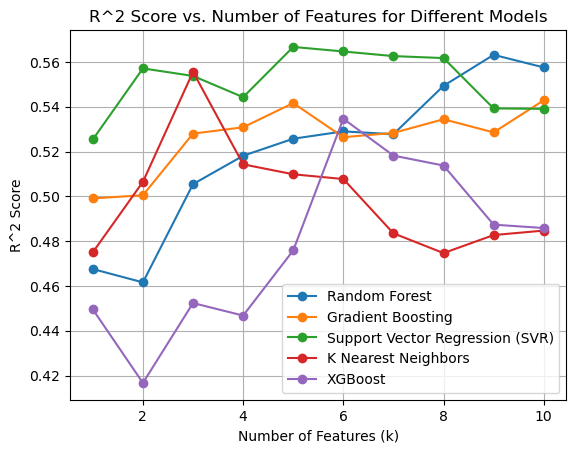

In [30]:
plt.plot(k_values, random_forest_r2_scores, label='Random Forest', marker='o')
plt.plot(k_values, gradient_boosting_r2_scores, label='Gradient Boosting', marker='o')
plt.plot(k_values, svm_r2_scores, label='Support Vector Regression (SVR)', marker='o')
plt.plot(k_values, knn_r2_scores, label='K Nearest Neighbors', marker='o')
plt.plot(k_values, xgboost_r2_scores, label='XGBoost', marker='o')

plt.xlabel('Number of Features (k)')
plt.ylabel('R^2 Score')
plt.title('R^2 Score vs. Number of Features for Different Models')
plt.legend()
plt.grid(True)
plt.show()


## (III) Weak Time Series Cross Validation of Models

In [31]:
def time_validate_mae(validation_model, data):

    model = validation_model
    mae_dict = {}
    
    for year in range(2009, 2020):
        X_train = data[data['Season'] < year].drop(columns=['Player', 'NY_SalaryUSD'])
        y_train = data[data['Season'] < year]['NY_SalaryUSD']
        X_test = data[data['Season'] == year].drop(columns=['Player', 'NY_SalaryUSD'])
        y_test = data[data['Season'] == year]['NY_SalaryUSD']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_dict[year] = mean_absolute_error(y_test, y_pred)

    return mae_dict

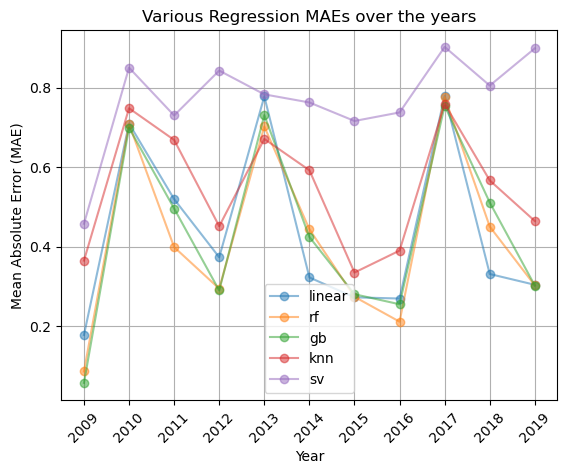

In [32]:
regression_model_dict = {
    'linear': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'sv': SVR()
}
for model_name, model_func in regression_model_dict.items():
    mae = time_validate_mae(model_func, batting_filtered)
    plt.plot(list(mae.keys()), list(mae.values()), marker='o', label = model_name, alpha=.5)

plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Various Regression MAEs over the years')
plt.legend()
plt.grid(True)
plt.xticks(list(mae.keys()), rotation=45)
plt.show()

# **Part 4: Bowling Models**

In [33]:
mean_target = y_train_bowl.mean()

y_pred_mean = np.full(y_test_bowl.shape, mean_target)

mae_mean = mean_absolute_error(y_test_bowl, y_pred_mean)
mse_mean = mean_squared_error(y_test_bowl, y_pred_mean)
r2_mean = r2_score(y_test_bowl, y_pred_mean)

print("Mean-Based Model:")
print("MAE:", mae_mean)
print("MSE:", mse_mean)
print("R^2:", r2_mean)

Mean-Based Model:
MAE: 0.7986299963832593
MSE: 0.9803286640522896
R^2: -0.0010170281054433516


## (I) Linear Models

In [34]:
linear_model = LinearRegression()
linear_model.fit(X_train_bowl, y_train_bowl)
y_pred_linear = linear_model.predict(X_test_bowl)

mae_linear = mean_absolute_error(y_test_bowl, y_pred_linear)
mse_linear = mean_squared_error(y_test_bowl, y_pred_linear)
r2_linear = r2_score(y_test_bowl, y_pred_linear)

print("\nLinear Regression Model:")
print("MAE:", mae_linear)
print("MSE:", mse_linear)
print("R^2:", r2_linear)


Linear Regression Model:
MAE: 0.47710613215221026
MSE: 0.49952592909229726
R^2: 0.4899323264356671


In [35]:
constant_feature_mask = X_train_bowl.apply(lambda col: col.nunique() != 1)
X_train_bowl = X_train_bowl.loc[:, constant_feature_mask]
X_test_bowl = X_test_bowl.loc[:, constant_feature_mask]

In [36]:
k=10
selector = SelectKBest(score_func=f_regression, k=k)

X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
X_test_bowl_selected = selector.transform(X_test_bowl)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_bowl.columns[selected_feature_indices]

In [37]:
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_bowl_selected, y_train_bowl)
y_pred_linear_selected = linear_model_selected.predict(X_test_bowl_selected)

mae_linear_selected = mean_absolute_error(y_test_bowl, y_pred_linear_selected)
mse_linear_selected = mean_squared_error(y_test_bowl, y_pred_linear_selected)
r2_linear_selected = r2_score(y_test_bowl, y_pred_linear_selected)

print("\nLinear Regression Model with Selected Features:")
print("Selected Features:", selected_feature_names)
print("MAE:", mae_linear_selected)
print("MSE:", mse_linear_selected)
print("R^2:", r2_linear_selected)


Linear Regression Model with Selected Features:
Selected Features: Index(['SalaryUSD', 'MatchCount', 'balls_bowled', 'total_runs',
       'total_wickets', '3whs', 'dots', '4s', '6s', 'Country_Uncapped'],
      dtype='object')
MAE: 0.4378457963862524
MSE: 0.4567031029058364
R^2: 0.533658864051179


In [38]:
k_values = range(1, 11)

linear_r2_scores = []
elastic_net_r2_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
    X_test_bowl_selected = selector.transform(X_test_bowl)

    linear_model_selected = LinearRegression()
    linear_model_selected.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_linear_selected = linear_model_selected.predict(X_test_bowl_selected)
    r2 = r2_score(y_test_bowl, y_pred_linear_selected)
    linear_r2_scores.append(r2)

    # ElasticNet Regression
    elastic_net_model = ElasticNet()
    elastic_net_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_elastic_net_selected = elastic_net_model.predict(X_test_bowl_selected)
    elastic_net_r2_scores.append(r2_score(y_test_bowl, y_pred_elastic_net_selected))

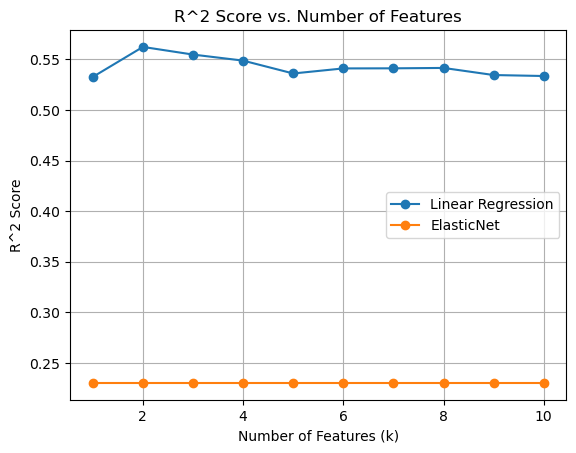

In [39]:
plt.plot(k_values, linear_r2_scores, label='Linear Regression', marker='o')
plt.plot(k_values, elastic_net_r2_scores, label='ElasticNet', marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('R^2 Score')
plt.title('R^2 Score vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

## (II) Other Models

In [40]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_bowl, y_train_bowl)
y_pred_rf = rf_model.predict(X_test_bowl)

mae_rf = mean_absolute_error(y_test_bowl, y_pred_rf)
mse_rf = mean_squared_error(y_test_bowl, y_pred_rf)
r2_rf = r2_score(y_test_bowl, y_pred_rf)

print("\nRandom Forest Regression Model:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("R^2:", r2_rf)


Random Forest Regression Model:
MAE: 0.4352772301600118
MSE: 0.44343914924768285
R^2: 0.5472027335295329


In [41]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train_bowl, y_train_bowl)
y_pred_gb = gb_model.predict(X_test_bowl)

mae_gb = mean_absolute_error(y_test_bowl, y_pred_gb)
mse_gb = mean_squared_error(y_test_bowl, y_pred_gb)
r2_gb = r2_score(y_test_bowl, y_pred_gb)

print("\nGradient Boosting Regression Model:")
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("R^2:", r2_gb)


Gradient Boosting Regression Model:
MAE: 0.43203503976998986
MSE: 0.4471887653820579
R^2: 0.5433739873783665


In [42]:
sv_model = SVR()
sv_model.fit(X_train_bowl, y_train_bowl)
y_pred_sv = sv_model.predict(X_test_bowl)

mae_sv = mean_absolute_error(y_test_bowl, y_pred_sv)
mse_sv = mean_squared_error(y_test_bowl, y_pred_sv)
r2_sv = r2_score(y_test_bowl, y_pred_sv)

print("\nSupport Vector Regression Model:")
print("MAE:", mae_sv)
print("MSE:", mse_sv)
print("R^2:", r2_sv)


Support Vector Regression Model:
MAE: 0.7665558322150996
MSE: 1.0189853346176163
R^2: -0.040489489642782095


In [43]:
k_values = range(1, 11)
random_forest_r2_scores = []
gradient_boosting_r2_scores = []
svm_r2_scores = []
knn_r2_scores = []
xgboost_r2_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
    X_test_bowl_selected = selector.transform(X_test_bowl)

    # Random Forest Regression
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_rf_selected = rf_model.predict(X_test_bowl_selected)
    random_forest_r2_scores.append(r2_score(y_test_bowl, y_pred_rf_selected))

    # Gradient Boosting Regression
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_gb_selected = gb_model.predict(X_test_bowl_selected)
    gradient_boosting_r2_scores.append(r2_score(y_test_bowl, y_pred_gb_selected))

    # Support Vector Regression (SVR)
    svr_model = SVR()
    svr_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_svr_selected = svr_model.predict(X_test_bowl_selected)
    svm_r2_scores.append(r2_score(y_test_bowl, y_pred_svr_selected))

    # K-Nearest Neighbors Regression
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_knn_selected = knn_model.predict(X_test_bowl_selected)
    knn_r2_scores.append(r2_score(y_test_bowl, y_pred_knn_selected))

    # XGBoost Regression
    xgboost_model = xgb.XGBRegressor()
    xgboost_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_xgboost_selected = xgboost_model.predict(X_test_bowl_selected)
    xgboost_r2_scores.append(r2_score(y_test_bowl, y_pred_xgboost_selected))

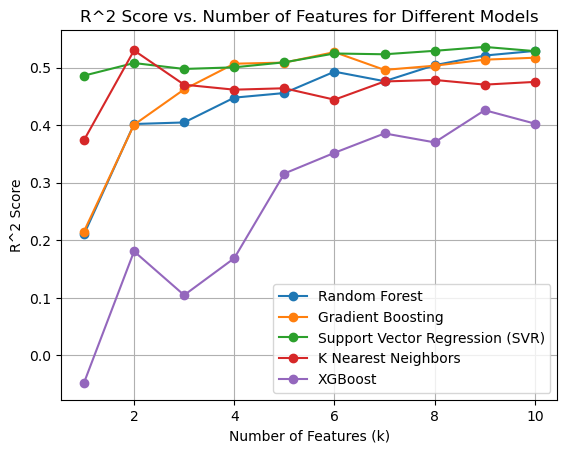

In [44]:
plt.plot(k_values, random_forest_r2_scores, label='Random Forest', marker='o')
plt.plot(k_values, gradient_boosting_r2_scores, label='Gradient Boosting', marker='o')
plt.plot(k_values, svm_r2_scores, label='Support Vector Regression (SVR)', marker='o')
plt.plot(k_values, knn_r2_scores, label='K Nearest Neighbors', marker='o')
plt.plot(k_values, xgboost_r2_scores, label='XGBoost', marker='o')

plt.xlabel('Number of Features (k)')
plt.ylabel('R^2 Score')
plt.title('R^2 Score vs. Number of Features for Different Models')
plt.legend()
plt.grid(True)
plt.show()


## (III) Weak Time Series Cross Validation of Models

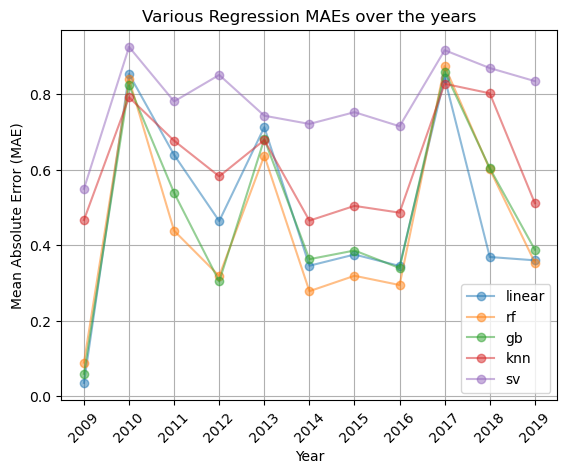

In [45]:
regression_model_dict = {
    'linear': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'sv': SVR()
}
for model_name, model_func in regression_model_dict.items():
    mae = time_validate_mae(model_func, bowling_filtered)
    plt.plot(list(mae.keys()), list(mae.values()), marker='o', label = model_name, alpha=.5)

plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Various Regression MAEs over the years')
plt.legend()
plt.grid(True)
plt.xticks(list(mae.keys()), rotation=45)
plt.show()

# **Part 5: Hyperparameter Tuning**

## (I) Batting Model

In [53]:
bat_selector = SelectKBest(score_func=f_regression, k=9)
X_train_bat_selected = bat_selector.fit_transform(X_train_bat, y_train_bat)
X_test_bat_selected = bat_selector.transform(X_test_bat)

In [56]:
param_grid = {
    'n_estimators': [1, 10, 100],           # Number of trees in the forest
    'max_depth': [None, 20, 25, 30],        # Maximum depth of each tree in the forest
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

batting_model = RandomForestRegressor()
batting_grid_search = GridSearchCV(batting_model, param_grid, scoring='neg_mean_absolute_error', cv=5)
batting_grid_search.fit(X_train_bat_selected, y_train_bat)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [57]:
best_params = batting_grid_search.best_params_
best_rf_model_bat = batting_grid_search.best_estimator_
y_pred_rf_tuned = best_rf_model_bat.predict(X_test_bat_selected)
r2_rf_tuned = r2_score(y_test_bat, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test_bat, y_pred_rf_tuned)

print("Best Hyperparameters for rf:", best_params)
print("Tuned rf R^2 Score:", r2_rf_tuned)
print("Tuned rf MAE Score:", mae_rf_tuned)

Best Hyperparameters for rf: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Tuned rf R^2 Score: 0.5614461257099999
Tuned rf MAE Score: 0.3982665009965783


## (II) Bowling Model

In [58]:
bowl_selector = SelectKBest(score_func=f_regression, k=10)
X_train_bowl_selected = bowl_selector.fit_transform(X_train_bowl, y_train_bowl)
X_test_bowl_selected = bowl_selector.transform(X_test_bowl)

In [59]:
param_grid = {
    'n_estimators': [1, 10, 100],           # Number of trees in the forest
    'max_depth': [None, 20, 25, 30],        # Maximum depth of each tree in the forest
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

bowling_model = RandomForestRegressor()
bowling_grid_search = GridSearchCV(bowling_model, param_grid, scoring='neg_mean_absolute_error', cv=5)
bowling_grid_search.fit(X_train_bowl_selected, y_train_bowl)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [60]:
best_params = bowling_grid_search.best_params_
best_rf_model_bowl = bowling_grid_search.best_estimator_
y_pred_rf_tuned = best_rf_model_bowl.predict(X_test_bowl_selected)
r2_rf_tuned = r2_score(y_test_bowl, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test_bowl, y_pred_rf_tuned)

print("Best Hyperparameters for rf:", best_params)
print("Tuned rf R^2 Score:", r2_rf_tuned)
print("Tuned rf MAE Score:", mae_rf_tuned)

Best Hyperparameters for rf: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Tuned rf R^2 Score: 0.5568295139941174
Tuned rf MAE Score: 0.4150087895778515
